In [1]:
!pip install pandas numpy xgboost seaborn scipy scikit-learn matplotlib optuna sentence-transformers shap



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 899.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitli

In [2]:
import pandas as pd
from functools import partial
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
import warnings
import logging
import ast
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import pickle
import optuna
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import shap
from google.colab import drive
import json



In [3]:
target_categories = {
    "Television": [
        "tv", "television", "hd tv", "smart tv", "flat screen", "led tv", "oled tv", "cable tv"
    ],
    "Wifi": [
        "wifi", "wi-fi", "wireless internet", "internet", "high speed internet", "free wifi"
    ],
    "CoffeeMaker": [
        "coffee maker", "espresso machine", "coffee machine", "nespresso", "french press"
    ],
    "Shampoo": [
        "shampoo", "hair shampoo", "shampoos"
    ],
    "Heating": [
        "heating", "central heating", "floor heating", "radiator", "heater"
    ],
    "Dishwasher": [
        "dishwasher", "dish washer"
    ],
    "Washer": [
        "washer", "washing machine", "laundry machine"
    ],
    "WineGlasses": [
        "wine glasses", "wine glass", "wine goblet"
    ],
    "PetsAllowed": [
        "pets allowed", "pet friendly", "pets welcome", "pets permitted"
    ],
    "PatioOrBalcony": [
        "patio", "balcony", "terrace", "outdoor seating", "deck"
    ],
    "Towels": [
        "towels", "bath towels", "clean towels"
    ],
    "AirConditioning": [
        "air conditioning", "ac", "air conditioner", "cooling"
    ],
    "Parking": [
        "parking", "free parking", "private parking", "parking spot"
    ],
    "Kitchen": [
        "kitchen", "full kitchen", "kitchenette", "cooking basics"
    ],
    "Pool": [
        "pool", "swimming pool", "heated pool"
    ],
    "Elevator": [
        "elevator", "lift"
    ],
    "Gym": [
        "gym", "fitness center", "fitness room", "workout room"
    ],
    "Fireplace": [
        "fireplace", "wood stove"
    ],
    "Breakfast": [
        "breakfast included", "free breakfast", "breakfast"
    ]
}

In [4]:
class NumericalImputer(BaseEstimator, TransformerMixin):
    """Class for imputing numerical columns with HistGradientBoostingRegressor"""
    def __init__(self, model=HistGradientBoostingRegressor()):
        self.model = model
        self.numerical_columns = None
        self.models = {}

    def fit(self, X, y=None):
        X = X.copy()

        self.numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

        for col in self.numerical_columns:
            X_features = X[self.numerical_columns].drop(columns=[col])
            mask = X[col].notna()

            X_train = X_features.loc[mask]
            y_train = X.loc[mask, col]

            if len(X_train) > 10:
                model = clone(self.model)
                model.fit(X_train, y_train)
                self.models[col] = model

        return self

    def transform(self, X):
        X_copy = X.copy()

        for col in self.numerical_columns:
            mask = X_copy[col].isna()
            if mask.sum() == 0:
                continue

            if col in self.models:
                X_features = X_copy[self.numerical_columns].drop(columns=[col])
                X_missing = X_features.loc[mask]

                predicted = self.models[col].predict(X_missing)
                X_copy.loc[mask, col] = predicted

        return X_copy

In [5]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    """Class for imputing categorical columns with most frequent category"""
    def __init__(self):
        self.fill_values = {}

    def fit(self, X, y=None):
        X = X.copy()
        categorical_columns = X.select_dtypes(include=['object', 'category']).columns

        for col in categorical_columns:
            if X[col].isnull().any():
                self.fill_values[col] = X[col].mode()[0]
        return self

    def transform(self, X):
        X = X.copy()
        for col, fill_value in self.fill_values.items():
            X[col] = X[col].fillna(fill_value)
        return X

In [6]:
class XYOutlierRemover:
    """Class that removes outliers in target and features"""
    # only extreme outliers are removed
    def __init__(self, iqr_multiplier=3.0):
        self.iqr_multiplier = iqr_multiplier
        self.boundaries_X = {}
        self.boundaries_y = None

    def fit(self, X, y):
        X = X.copy()
        y = y.copy()

        for col in X.select_dtypes(include=['float64', 'int64']).columns:
            if X[col].nunique() <= 1:
                continue
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            if IQR == 0:
                continue
            lower = Q1 - self.iqr_multiplier * IQR
            upper = Q3 + self.iqr_multiplier * IQR
            self.boundaries_X[col] = (lower, upper)

        Q1 = y.quantile(0.25)
        Q3 = y.quantile(0.75)
        IQR = Q3 - Q1
        if IQR == 0:
            self.boundaries_y = (y.min(), y.max())
        else:
            self.boundaries_y = (Q1 - self.iqr_multiplier * IQR, Q3 + self.iqr_multiplier * IQR)

        return self

    def transform(self, X, y):
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        mask = np.ones(len(X), dtype=bool)

        # if mask is False in any column/target, the row gets removed
        for col, (lower, upper) in self.boundaries_X.items():
            if col in X.columns:
                col_mask = (X[col] >= lower) & (X[col] <= upper)
                mask &= col_mask

        if self.boundaries_y:
            y_mask = (y >= self.boundaries_y[0]) & (y <= self.boundaries_y[1])
            mask &= y_mask

        removed_ratio = (~mask).sum() / len(mask)
        if removed_ratio > 0.25 or mask.sum() == 0:
            return X, y

        return X[mask].reset_index(drop=True), y[mask].reset_index(drop=True)

In [7]:
class AmenityExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, target_categories=None):
        self.target_categories = target_categories or {}
        self.category_labels = list(self.target_categories.keys())

    def fit(self, X, y=None):
        return self

    def assign_categories(self, amenity_list):
        amenity_list = [item.lower().strip() for item in amenity_list if isinstance(item, str)]
        matches = set()
        for category, phrases in self.target_categories.items():
            for phrase in phrases:
                phrase = phrase.lower().strip()
                if any(phrase in amenity for amenity in amenity_list):
                    matches.add(category)
                    break
        return matches

    def transform(self, X):
        df = X.copy()
        if 'amenities' not in df.columns:
            raise ValueError("Column 'amenities' is required in input DataFrame")

        results = []
        for idx, text in enumerate(df['amenities']):
            try:
                items = json.loads(text) if isinstance(text, str) else []
            except Exception:
                items = []
            matched = self.assign_categories(items)
            row = {label: int(label in matched) for label in self.category_labels}
            results.append(row)

        amenity_df = pd.DataFrame(results).astype("category")
        df = df.drop("amenities", axis=1)
        df = pd.concat([df.reset_index(drop=True), amenity_df.reset_index(drop=True)], axis=1)
        return df

"""Anemnity extractor with TF-IDF + cosine similarity for fuzzy matching. This solution is more time-consuming."""
# class AmenityExtractorTFIDF(BaseEstimator, TransformerMixin):
#     """Amenity extraction with TF-IDF + cosine similarity for fuzzy matching"""
#     def __init__(self, target_categories=None, similarity_threshold=0.3):
#         self.target_categories = target_categories
#         self.similarity_threshold = similarity_threshold
#         self.vectorizer = TfidfVectorizer()
#         self.category_examples = []
#         self.category_labels = []
#         self.category_labels_unique = list(target_categories.keys())
#         self.X_train_tfidf = None

#     def fit(self, X, y=None):
#         for label, phrases in self.target_categories.items():
#             for phrase in phrases:
#                 self.category_examples.append(phrase.lower())
#                 self.category_labels.append(label)
#         self.X_train_tfidf = self.vectorizer.fit_transform(self.category_examples)
#         return self

#     def assign_categories(self, amenity_list):
#         matches = set()
#         for item in amenity_list:
#             item = item.strip().lower()
#             if not item:
#                 continue
#             item_vector = self.vectorizer.transform([item])
#             similarities = cosine_similarity(item_vector, self.X_train_tfidf)[0]
#             for idx, score in enumerate(similarities):
#                 if score >= self.similarity_threshold:
#                     matches.add(self.category_labels[idx])
#         return matches

#     def transform(self, X):
#         df = X.copy()
#         if 'amenities' not in df.columns:
#             raise ValueError("Column 'amenities' is required in input DataFrame")

#         results = []
#         for text in df['amenities']:
#             try:
#                 split_items = [item.lower() for item in ast.literal_eval(text)] if isinstance(text, str) else []
#             except:
#                 split_items = []
#             matched = self.assign_categories(split_items)
#             row = {label: int(label in matched) for label in self.category_labels_unique}
#             results.append(row)

#         amenity_df = pd.DataFrame(results).astype("category")
#         df = df.drop("amenities", axis=1)
#         df = pd.concat([df.reset_index(drop=True), amenity_df.reset_index(drop=True)], axis=1)
#         return df

'Anemnity extractor with TF-IDF + cosine similarity for fuzzy matching. This solution is more time-consuming.'

In [8]:
def evaluate_model(model, X_train, y_train, n_splits=3, seed=42):
    # function that performs crossvalidation and finds the best model based on hyperparameters and its score on validation data
    scores_learning_curve = []
    imputers = []
    encoders = []
    scalers = []
    scores = []
    train_errors = []
    val_errors = []
    xy_outlier_removers = []
    extractors = []


    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx].copy()
        X_val = X_train.iloc[val_idx].copy()
        y_tr = y_train.iloc[train_idx].copy()
        y_val = y_train.iloc[val_idx].copy()
        print("X_tr_head()")
        print(X_tr.head())

        extractor = AmenityExtractor(target_categories=target_categories)
        extractor.fit(X_tr)

        X_tr = extractor.transform(X_tr)
        X_val = extractor.transform(X_val)
        extractors.append(extractor)

        print(X_tr.head())

        num_imputer = NumericalImputer().fit(X_tr)
        X_tr = num_imputer.transform(X_tr)
        X_val = num_imputer.transform(X_val)

        categorical_columns = X_tr.select_dtypes(include=['object', 'category']).columns.tolist()

        numeric_columns = X_tr.select_dtypes(include=["int64", "float64"]).columns

        categorical_imputer = CategoricalImputer().fit(X_tr)
        X_tr = categorical_imputer.transform(X_tr)
        X_val = categorical_imputer.transform(X_val)

        numeric_columns = X_tr.select_dtypes(include=["int64", "float64"]).columns
        if (np.any(np.isnan(X_tr[numeric_columns])) or np.any(np.isinf(X_tr[numeric_columns])) or
            np.any(np.isnan(X_val[numeric_columns])) or np.any(np.isinf(X_val[numeric_columns])) or
            np.any(np.isnan(y_tr)) or np.any(np.isinf(y_tr)) or
            np.any(np.isnan(y_val)) or np.any(np.isinf(y_val))):
            print("NaN/inf values — fold skipped")
            continue

        xy_outlier_remover = XYOutlierRemover(iqr_multiplier=3.0)
        xy_outlier_remover.fit(X_tr, y_tr)
        X_tr, y_tr = xy_outlier_remover.transform(X_tr, y_tr)
        X_val, y_val = xy_outlier_remover.transform(X_val, y_val)


        existing_categorical_columns = [col for col in categorical_columns if col in X_tr.columns]
        if existing_categorical_columns:
            encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

            X_tr_encoded = encoder.fit_transform(X_tr[existing_categorical_columns])
            X_val_encoded = encoder.transform(X_val[existing_categorical_columns])

            encoded_columns = encoder.get_feature_names_out(existing_categorical_columns)

            X_tr = X_tr.drop(columns=existing_categorical_columns).reset_index(drop=True)
            X_val = X_val.drop(columns=existing_categorical_columns).reset_index(drop=True)

            X_tr_encoded_df = pd.DataFrame(X_tr_encoded, columns=encoded_columns)
            X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=encoded_columns)

            X_tr = pd.concat([X_tr, X_tr_encoded_df], axis=1)
            X_val = pd.concat([X_val, X_val_encoded_df], axis=1)

            encoders.append(encoder)

        else:
            print("No categorical columns for encdoing.")
            encoders.append(None)

        # normalization of the data, for xgbregressor its not neccesary
        scaler = MinMaxScaler()
        X_tr[numeric_columns] = scaler.fit_transform(X_tr[numeric_columns])
        X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])

        scalers.append(scaler)


        processed_data_path = 'data/processed/'
        os.makedirs(processed_data_path, exist_ok=True)
        X_tr.to_csv(processed_data_path + 'X_processed.csv', index=False)
        y_tr.to_csv(processed_data_path + 'y_processed.csv', index=False)

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        score = -mean_absolute_error(y_val, preds)
        scores.append(score)
        imputers.append((num_imputer, categorical_imputer))


        xy_outlier_removers.append(xy_outlier_remover)


        print(f"Score: {score}")
        print(f"Prediction: {preds[:5]}...")

    if not scores:
        print("No valid folds")
        return float("-inf"), None, None, None, None

    return np.mean(scores), imputers[-1][0], imputers[-1][1], encoders[-1], scalers[-1],  X_tr, y_tr, X_val, y_val, xy_outlier_removers[-1], extractors[-1]

In [9]:
def clean_verifications(val):
    # cleans verification column – turns list string into sorted string like 'email_phone', returns None if bad input
    if pd.isnull(val):
        return None
    try:
        items = ast.literal_eval(val)
        if isinstance(items, list):
            return "_".join(sorted(items))
    except:
        return None

In [10]:
def objective(trial, X_train, y_train):
    # objective function of optuna, this function returns encoders etc. so they can be extracted later
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 250, 450),
    "booster": "gbtree",
    "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.3, log=True),
    "max_depth": trial.suggest_int("max_depth", 3, 5),
    "min_child_weight": trial.suggest_int("min_child_weight", 5, 15),
    "subsample": trial.suggest_float("subsample", 0.7, 0.85),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.85),
    "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 5.0),
    "gamma": trial.suggest_float("gamma", 1.0, 5.0),
    "reg_alpha": trial.suggest_float("reg_alpha", 1.0, 5.0),
    "tree_method": "hist",
    "random_state": 42,
    "n_jobs": -1
}



    print(f"Testing trial with params: {params}")

    try:
        model = xgb.XGBRegressor(**params)

        numerical_columns = X_train.select_dtypes(include=["number"]).columns

        score, num_imputer, cat_imputer, encoder, scaler, X_tr, y_tr, x_val, y_val, xy_outlier_remover, extractor = evaluate_model(model, X_train, y_train, n_splits=3)


        print(f"Score: {score}, type: {type(score)}")
        if np.isnan(score) or np.isinf(score):
            print(f"[Trial {trial.number}] Invalid score: {score}")
            return float("-inf")

        trial.set_user_attr("model", model)
        trial.set_user_attr("imputers", (num_imputer, cat_imputer))
        trial.set_user_attr("encoder", encoder)
        trial.set_user_attr("scaler", scaler)
        trial.set_user_attr("x_tr", X_tr)
        trial.set_user_attr("y_tr", y_tr)
        trial.set_user_attr("x_val", x_val)
        trial.set_user_attr("y_val", y_val)
        trial.set_user_attr("xy_outlier_removers", xy_outlier_remover)
        trial.set_user_attr("extractor", extractor)

        print(f"[Trial {trial.number}] Done with score: {score}")
        return score

    except Exception as e:
        print(f"[Trial {trial.number}] Error: {e}")
        return float("-inf")

In [11]:
def plot_learning_curve_vs_data_size(estimator, X, y, scoring="neg_mean_squared_error", cv=3, train_sizes=np.linspace(0.1, 1.0, 10)):
    # function for plotting learning curve based on error and number of samples
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring=scoring,
        train_sizes=train_sizes,
        n_jobs=-1
    )

    train_errors = -np.mean(train_scores, axis=1)
    val_errors = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_errors, 'o-', label='Training Error')
    plt.plot(train_sizes, val_errors, 'o-', label='Validation Error')
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve (Train Size vs Error)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
def remove_percentage_and_convert_column(df, column_name):
    # function that removes percentage
    df[column_name] = df[column_name].replace({'%': ''}, regex=True).astype(float) / 100
    return df

In [13]:
def extract_year(date_str):
    # function for extraction of the year
    if pd.isna(date_str):
        return None

    if isinstance(date_str, float):
        return int(date_str)

    if isinstance(date_str, str):
        try:
            if "/" in date_str:
                return int(date_str.split("/")[-1])
            elif "-" in date_str:
                return int(date_str.split("-")[0])
            else:
                raise ValueError(f"Unknown date format: {date_str}")
        except Exception as e:
            print(f"Error processing date: {e}")
            return None
    else:
        return None


In [14]:
def transform_with_best_pipeline(X_trans, num_imputer, cat_imputer, encoder, scaler, extractor, X_train_columns):
    # method for transformation of text data
    X_trans = extractor.transform(X_trans)
    X_trans = num_imputer.transform(X_trans)

    X_trans = cat_imputer.transform(X_trans)

    if encoder:
        categorical_columns = [col for col in X_trans.columns if X_trans[col].dtype in ['object', 'category']]

        if categorical_columns:
            X_encoded = encoder.transform(X_trans[categorical_columns])

            X_trans = X_trans.drop(columns=categorical_columns).reset_index(drop=True)

            new_columns = encoder.get_feature_names_out(categorical_columns)

            X_encoded_df = pd.DataFrame(X_encoded, columns=new_columns)

            X_trans = pd.concat([X_trans.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)


    if scaler:
      numeric_cols = [col for col in X_trans.select_dtypes(include=["int64", "float64"]).columns if set(X_trans[col].dropna().unique()) - {0, 1}]
      X_trans[numeric_cols] = scaler.transform(X_trans[numeric_cols])

    return X_trans


In [15]:

pd.set_option('display.max_columns', None)

In [16]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/DataXproject/listings.csv'
df = pd.read_csv(file_path)


Mounted at /content/drive


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:

print(df.head())

       id                          listing_url       scrape_id last_scraped  \
0   23163   https://www.airbnb.com/rooms/23163  20250316041547   2025-03-16   
1   23169   https://www.airbnb.com/rooms/23169  20250316041547   2025-03-16   
2   26755   https://www.airbnb.com/rooms/26755  20250316041547   2025-03-16   
3  782440  https://www.airbnb.com/rooms/782440  20250316041547   2025-03-16   
4  782489  https://www.airbnb.com/rooms/782489  20250316041547   2025-03-16   

        source                                 name  \
0  city scrape         Residence Karolina - KAROL12   
1  city scrape           Residence Masna - Masna302   
2  city scrape    Central Prague Old Town Top Floor   
3  city scrape  Central,Cheap&Lovely Miniapartment2   
4  city scrape  Central,Cheap&Lovely Miniapartment3   

                                         description  \
0  Unique and elegant apartment rental in Prague,...   
1  Masna studio offers a lot of space and privacy...   
2  Big and beautiful new a

In [19]:
print(df.describe(include="all"))

                  id                                       listing_url  \
count   1.010800e+04                                             10108   
unique           NaN                                             10108   
top              NaN  https://www.airbnb.com/rooms/1376687962067046501   
freq             NaN                                                 1   
mean    6.108089e+17                                               NaN   
std     5.380318e+17                                               NaN   
min     2.316300e+04                                               NaN   
25%     3.280956e+07                                               NaN   
50%     7.446005e+17                                               NaN   
75%     1.128376e+18                                               NaN   
max     1.376688e+18                                               NaN   

           scrape_id last_scraped       source  \
count   1.010800e+04        10108        10108   
unique     

In [20]:
df.drop_duplicates()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,23163,https://www.airbnb.com/rooms/23163,20250316041547,2025-03-16,city scrape,Residence Karolina - KAROL12,"Unique and elegant apartment rental in Prague,...",NaN,https://a0.muscache.com/pictures/01bbe32c-3f13...,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Czechia","Hello, \r\nglad to see that you are interested...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/b7309...,https://a0.muscache.com/im/pictures/user/b7309...,Josefov,72.0,82.0,"['email', 'phone']",t,t,NaN,Praha 1,NaN,50.082290,14.415520,Entire rental unit,Entire home/apt,4,1.0,1 bath,1.0,2.0,"[""Coffee maker"", ""Dishwasher"", ""Bed linens"", ""...","$2,918.00",1,365,1,7,60,731,1.4,663.6,NaN,t,0,0,0,0,2025-03-16,31,1,0,0,1,6,17508.0,2010-09-20,2024-06-15,4.90,4.83,5.00,5.00,4.97,4.93,4.86,NaN,t,70,69,0,0,0.18
1,23169,https://www.airbnb.com/rooms/23169,20250316041547,2025-03-16,city scrape,Residence Masna - Masna302,Masna studio offers a lot of space and privacy...,NaN,https://a0.muscache.com/pictures/b450cf2a-8561...,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Czechia","Hello, \r\nglad to see that you are interested...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/b7309...,https://a0.muscache.com/im/pictures/user/b7309...,Josefov,72.0,82.0,"['email', 'phone']",t,t,NaN,Praha 1,NaN,50.088300,14.422720,Entire rental unit,Entire home/apt,3,1.0,1 bath,1.0,2.0,"[""Patio or balcony"", ""Coffee maker"", ""Bed line...",NaN,1,365,1,7,60,731,1.2,710.6,NaN,t,7,13,13,13,2025-03-16,122,6,0,13,8,36,NaN,2010-05-07,2024-11-08,4.74,4.60,4.83,4.81,4.87,4.97,4.70,NaN,t,70,69,0,0,0.67
2,26755,https://www.airbnb.com/rooms/26755,20250316041547,2025-03-16,city scrape,Central Prague Old Town Top Floor,Big and beautiful new attic apartment in the v...,This apartment offers a fantastic location. Yo...,https://a0.muscache.com/pictures/miso/Hosting-...,113902,https://www.airbnb.com/users/show/113902,Daniel+Bea,2010-04-26,"Prague, Czechia",Hi! we are a sp/cz couple with 2 daughters (La...,within an hour,100%,98%,t,https://a0.muscache.com/im/pictures/user/8db01...,https://a0.muscache.com/im/pictures/user/8db01...,Staré Město,4.0,4.0,"['email', 'phone']",t,t,"Prague, Hlavní město Praha, Czechia",Praha 1,NaN,50.087290,14.431790,Entire rental unit,Entire home/apt,4,1.5,1.5 baths,1.0,2.0,"[""AC - split type ductless system"", ""Coffee ma...","$1,582.00",3,700,3,4,1125,1125,3.1,1125.0,NaN,t,3,7,24,173,2025-03-16,411,53,3,173,57,255,403410.0,2015-05-19,2025-03-07,4.94,4.95,4.92,4.93,4.96,4.93,4.90,NaN,f,3,3,0,0,3.43
3,7

In [21]:
print(df.isnull().sum())

id                                                0
listing_url                                       0
scrape_id                                         0
last_scraped                                      0
source                                            0
                                               ... 
calculated_host_listings_count                    0
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                               975
Length: 79, dtype: int64


In [22]:
df["price"] = df["price"].replace(r"[\$,]", "", regex=True).astype(float)

In [23]:
df["price"].describe()

,price
count,8808.000000
mean,2730.524977
std,8349.628162
min,223.000000
25%,1242.750000
50%,1762.000000
75%,2641.000000
max,251025.000000


In [24]:
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,23163,https://www.airbnb.com/rooms/23163,20250316041547,2025-03-16,city scrape,Residence Karolina - KAROL12,"Unique and elegant apartment rental in Prague,...",NaN,https://a0.muscache.com/pictures/01bbe32c-3f13...,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Czechia","Hello, \r\nglad to see that you are interested...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/b7309...,https://a0.muscache.com/im/pictures/user/b7309...,Josefov,72.0,82.0,"['email', 'phone']",t,t,NaN,Praha 1,NaN,50.08229,14.41552,Entire rental unit,Entire home/apt,4,1.0,1 bath,1.0,2.0,"[""Coffee maker"", ""Dishwasher"", ""Bed linens"", ""...",2918.0,1,365,1,7,60,731,1.4,663.6,NaN,t,0,0,0,0,2025-03-16,31,1,0,0,1,6,17508.0,2010-09-20,2024-06-15,4.90,4.83,5.00,5.00,4.97,4.93,4.86,NaN,t,70,69,0,0,0.18
1,23169,https://www.airbnb.com/rooms/23169,20250316041547,2025-03-16,city scrape,Residence Masna - Masna302,Masna studio offers a lot of space and privacy...,NaN,https://a0.muscache.com/pictures/b450cf2a-8561...,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Czechia","Hello, \r\nglad to see that you are interested...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/b7309...,https://a0.muscache.com/im/pictures/user/b7309...,Josefov,72.0,82.0,"['email', 'phone']",t,t,NaN,Praha 1,NaN,50.08830,14.42272,Entire rental unit,Entire home/apt,3,1.0,1 bath,1.0,2.0,"[""Patio or balcony"", ""Coffee maker"", ""Bed line...",NaN,1,365,1,7,60,731,1.2,710.6,NaN,t,7,13,13,13,2025-03-16,122,6,0,13,8,36,NaN,2010-05-07,2024-11-08,4.74,4.60,4.83,4.81,4.87,4.97,4.70,NaN,t,70,69,0,0,0.67
2,26755,https://www.airbnb.com/rooms/26755,20250316041547,2025-03-16,city scrape,Central Prague Old Town Top Floor,Big and beautiful new attic apartment in the v...,This apartment offers a fantastic location. Yo...,https://a0.muscache.com/pictures/miso/Hosting-...,113902,https://www.airbnb.com/users/show/113902,Daniel+Bea,2010-04-26,"Prague, Czechia",Hi! we are a sp/cz couple with 2 daughters (La...,within an hour,100%,98%,t,https://a0.muscache.com/im/pictures/user/8db01...,https://a0.muscache.com/im/pictures/user/8db01...,Staré Město,4.0,4.0,"['email', 'phone']",t,t,"Prague, Hlavní město Praha, Czechia",Praha 1,NaN,50.08729,14.43179,Entire rental unit,Entire home/apt,4,1.5,1.5 baths,1.0,2.0,"[""AC - split type ductless system"", ""Coffee ma...",1582.0,3,700,3,4,1125,1125,3.1,1125.0,NaN,t,3,7,24,173,2025-03-16,411,53,3,173,57,255,403410.0,2015-05-19,2025-03-07,4.94,4.95,4.92,4.93,4.96,4.93,4.90,NaN,f,3,3,0,0,3.43
3,782440,https://ww

In [25]:
drop_cols = [ "id", "name", "description", "license", "host_id", "host_name", "host_about", "neighborhood_overview", "neighbourhood_group_cleansed", "neighbourhood",
            "listing_url", "calendar_updated", "scrape_id", "last_scraped", "host_thumbnail_url", "listing_url", "picture_url", "host_url", "host_picture_url", "latitude","longitude", "calendar_last_scraped", "estimated_revenue_l365d", "estimated_occupancy_l365d"
    ]

In [26]:
cat_columns = [ "host_url", "host_is_superhost", "host_verifications", "host_has_profile_pic", "host_identity_verified", "neighbourhood_cleansed" " property_type", "room_type", "bathrooms_text", "has_availability", "instant_bookable", "host_verifications", "host_has_profile_pic", "host_identity_verified", "has_availability", "instant_bookable"
    ]

In [27]:
perc_col = ["host_response_rate", "host_acceptance_rate"]

In [28]:
df = df.drop(columns = drop_cols, axis = 1)

In [29]:
for column in perc_col:
    df = remove_percentage_and_convert_column(df, column)

In [30]:
df['host_since'] = df['host_since'].apply(extract_year)
df['host_since'] = df['host_since'].astype('float64')


df["first_review"]= df["first_review"].apply(extract_year)
df['first_review'] = df['first_review'].astype('float64')


df["last_review"]= df["last_review"].apply(extract_year)
df["last_review"] = df["last_review"].astype('float64')



In [31]:
df[["first_review", "last_review"]] = df[["first_review", "last_review"]].fillna(1900)

In [32]:
numerical_columns = df.select_dtypes(include=["number"]).columns
numerical_columns = numerical_columns.drop("price", errors="ignore")
for col in numerical_columns:

    df[col] = df[col].astype('float64')

categorical_columns = df.select_dtypes(include=["object", "category"]).columns
for col in categorical_columns:
    df[col] = df[col].astype("category")

categorical_columns

Index(['source', 'host_location', 'host_response_time', 'host_is_superhost',
       'host_neighbourhood', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'bathrooms_text', 'amenities', 'has_availability',
       'instant_bookable'],
      dtype='object')

In [33]:
df['price'] = df['price'].replace('NA', np.nan)

df = df[~df['price'].isna()]
df = df[df['price'].apply(lambda x: abs(x) >= 0.01)]

In [34]:
interim_data_path = 'data/interim/listings_interim.csv'
os.makedirs(os.path.dirname(interim_data_path), exist_ok=True)
df.to_csv(interim_data_path, index=False)

In [35]:
df['host_verifications'] = df['host_verifications'].apply(clean_verifications)


In [36]:
df.columns = df.columns.str.replace(r'[^A-Za-z0-9_]+', '', regex=True)


In [37]:
for col in numerical_columns:
    df[col] = df[col].replace('NA', np.nan)


In [38]:
X = df.drop("price",axis=1)
y = df["price"]

The column Price was dropped from X, but it's generally recommended to explicitly define the input features for prediction — in case the database structure changes.

In [39]:
X.head()


,source,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,city scrape,2008.0,"Prague, Czechia",within an hour,1.0,1.00,t,Josefov,72.0,82.0,email_phone,t,t,Praha 1,Entire rental unit,Entire home/apt,4.0,1.0,1 bath,1.0,2.0,"[""Coffee maker"", ""Dishwasher"", ""Bed linens"", ""...",1.0,365.0,1.0,7.0,60.0,731.0,1.4,663.6,t,0.0,0.0,0.0,0.0,31.0,1.0,0.0,0.0,1.0,2010.0,2024.0,4.90,4.83,5.00,5.00,4.97,4.93,4.86,t,70.0,69.0,0.0,0.0,0.18
2,city scrape,2010.0,"Prague, Czechia",within an hour,1.0,0.98,t,Staré Město,4.0,4.0,email_phone,t,t,Praha 1,Entire rental unit,Entire home/apt,4.0,1.5,1.5 baths,1.0,2.0,"[""AC - split type ductless system"", ""Coffee ma...",3.0,700.0,3.0,4.0,1125.0,1125.0,3.1,1125.0,t,3.0,7.0,24.0,173.0,411.0,53.0,3.0,173.0,57.0,2015.0,2025.0,4.94,4.95,4.92,4.93,4.96,4.93,4.90,f,3.0,3.0,0.0,0.0,3.43
3,city scrape,2012.0,"Prague, Czechia",within an hour,1.0,0.80,t,Žižkov,6.0,6.0,email_phone,t,t,Praha 3,Private room in rental unit,Private room,2.0,1.0,1 private bath,1.0,2.0,"[""Coffee maker"", ""Bed linens"", ""Dishes and sil...",3.0,60.0,1.0,3.0,60.0,60.0,3.0,60.0,t,5.0,5.0,5.0,5.0,414.0,52.0,5.0,5.0,52.0,2013.0,2025.0,4.76,4.85,4.71,4.94,4.95,4.63,4.83,f,6.0,3.0,3.0,0.0,2.79
4,city scrape,2012.0,"Prague, Czechia",within an hour,1.0,0.80,t,Žižkov,6.0,6.0,email_phone,t,t,Praha 3,Private room in rental unit,Private room,2.0,1.0,1 private bath,1.0,3.0,"[""Coffee maker"", ""Bed linens"", ""Dishes and sil...",3.0,60.0,3.0,3.0,60.0,60.0,3.0,60.0,t,3.0,3.0,3.0,3.0,389.0,47.0,3.0,3.0,48.0,2013.0,2025.0,4.69,4.79,4.58,4.89,4.90,4.59,4.73,f,6.0,3.0,3.0,0.0,2.67
5,city scrape,2012.0,"Prague, Czechia",within an hour,1.0,0.80,t,Žižkov,6.0,6.0,email_phone,t,t,Praha 3,Private room in rental unit,Private room,2.0,1.0,1 private bath,1.0,1.0,"[""Coffee maker"", ""Bed linens"", ""Dishes and sil...",3.0,60.0,3.0,3.0,60.0,60.0,3.0,60.0,t,6.0,6.0,6.0,6.0,381.0,52.0,2.0,6.0,53.0,2013.0,2025.0,4.78,4.90,4.64,4.91,4.93,4.68,4.81,f,6.0,3.0,3.0,0.0,2.58


In [40]:
# train test split with suffle = True so there is no pattern in records
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=15, shuffle = True)

In [41]:
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
optuna_objective = partial(objective, X_train=X_train, y_train=y_train)
# n_trials intially set to higher values n_trials = 50 and more
study.optimize(optuna_objective, n_trials=10, show_progress_bar=False)


best_trial = study.best_trial
best_model = best_trial.user_attrs["model"]
num_imputer = best_trial.user_attrs["imputers"][0]
cat_imputer = best_trial.user_attrs["imputers"][1]
encoder = best_trial.user_attrs.get("encoder")
scaler = best_trial.user_attrs.get("scaler")
extractor = best_trial.user_attrs.get("extractor")
x_tr = best_trial.user_attrs.get("x_tr")
y_tr = best_trial.user_attrs.get("y_tr")
x_val = best_trial.user_attrs.get("x_val")
y_val = best_trial.user_attrs.get("y_val")


[I 2025-07-14 13:23:57,131] A new study created in memory with name: no-name-4d9977a5-6d92-4fa4-9c15-3ccbe07a1b1a


Testing trial with params: {'n_estimators': 325, 'booster': 'gbtree', 'learning_rate': 0.262516606324193, 'max_depth': 5, 'min_child_weight': 11, 'subsample': 0.7234027960663655, 'colsample_bytree': 0.7233991780504303, 'reg_lambda': 1.2323344486727978, 'gamma': 4.46470458309974, 'reg_alpha': 3.404460046972835, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}
X_tr_head()
           source  host_since    host_location host_response_time  \
8160  city scrape      2021.0  Prague, Czechia     within an hour   
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
8160                 1.0                  1.00                 f   
9501                 1.0                  0.98                 f   


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 6, 7, 8, 9, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -2078.983817943262
Prediction: [1673.5638   926.3148  2499.8196   789.25085  681.2165 ]...
X_tr_head()
           source  host_since    host_location host_response_time  \
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   
588   city scrape      2012.0  Prague, Czechia     within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
9501                 1.0                  0.98                 f   
4219                 1.0                  1.00                 t   
987                  1.0                  0.96                 t   
3755                 1.0                  0.98                 f   
588                  1.0                  1.00                 t   

     host_neighbourhood  host_listings_count  host_total_listings_

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 8, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -2076.429724902384
Prediction: [-1.3422127e+00  1.5571285e+03  1.7554390e+03  4.3500503e+03
  1.5303214e+04]...
X_tr_head()
           source  host_since    host_location  host_response_time  \
8160  city scrape      2021.0  Prague, Czechia      within an hour   
386   city scrape      2014.0  Prague, Czechia      within an hour   
5497  city scrape      2015.0  Prague, Czechia  within a few hours   
1802  city scrape      2012.0  Prague, Czechia      within an hour   
4237  city scrape      2021.0  Prague, Czechia      within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
8160                1.00                  1.00                 f   
386                 0.96                  0.94                 t   
5497                1.00                   NaN                 f   
1802                1.00                  1.00                 t   
4237                1.00                  1.00                 f   

     host_neighbourhood  host_listings_

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-07-14 13:25:06,668] Trial 0 finished with value: -2058.649776709499 and parameters: {'n_estimators': 325, 'learning_rate': 0.262516606324193, 'max_depth': 5, 'min_child_weight': 11, 'subsample': 0.7234027960663655, 'colsample_bytree': 0.7233991780504303, 'reg_lambda': 1.2323344486727978, 'gamma': 4.46470458309974, 'reg_alpha': 3.404460046972835}. Best is trial 0 with value: -2058.649776709499.


Score: -2020.535787282851
Prediction: [1970.4148 2782.4763 5340.235  6079.8804 2013.7872]...
Score: -2058.649776709499, type: <class 'numpy.float64'>
[Trial 0] Done with score: -2058.649776709499
Testing trial with params: {'n_estimators': 392, 'booster': 'gbtree', 'learning_rate': 0.021146536167031597, 'max_depth': 5, 'min_child_weight': 14, 'subsample': 0.7318508666017414, 'colsample_bytree': 0.727273745081065, 'reg_lambda': 1.7336180394137353, 'gamma': 2.216968971838151, 'reg_alpha': 3.0990257265289514, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}
X_tr_head()
           source  host_since    host_location host_response_time  \
8160  city scrape      2021.0  Prague, Czechia     within an hour   
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   

    

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 6, 7, 8, 9, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1495.4615996491914
Prediction: [2445.4954 1577.7053 3557.686  1406.085  1456.0726]...
X_tr_head()
           source  host_since    host_location host_response_time  \
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   
588   city scrape      2012.0  Prague, Czechia     within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
9501                 1.0                  0.98                 f   
4219                 1.0                  1.00                 t   
987                  1.0                  0.96                 t   
3755                 1.0                  0.98                 f   
588                  1.0                  1.00                 t   

     host_neighbourhood  host_listings_count  host_total_listings_coun

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 8, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1435.5805299130843
Prediction: [2011.9927 1342.7101 3148.82   2572.3772 9839.577 ]...
X_tr_head()
           source  host_since    host_location  host_response_time  \
8160  city scrape      2021.0  Prague, Czechia      within an hour   
386   city scrape      2014.0  Prague, Czechia      within an hour   
5497  city scrape      2015.0  Prague, Czechia  within a few hours   
1802  city scrape      2012.0  Prague, Czechia      within an hour   
4237  city scrape      2021.0  Prague, Czechia      within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
8160                1.00                  1.00                 f   
386                 0.96                  0.94                 t   
5497                1.00                   NaN                 f   
1802                1.00                  1.00                 t   
4237                1.00                  1.00                 f   

     host_neighbourhood  host_listings_count  host_total_listing

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-07-14 13:26:12,317] Trial 1 finished with value: -1508.4877413306774 and parameters: {'n_estimators': 392, 'learning_rate': 0.021146536167031597, 'max_depth': 5, 'min_child_weight': 14, 'subsample': 0.7318508666017414, 'colsample_bytree': 0.727273745081065, 'reg_lambda': 1.7336180394137353, 'gamma': 2.216968971838151, 'reg_alpha': 3.0990257265289514}. Best is trial 1 with value: -1508.4877413306774.


Score: -1594.421094429757
Prediction: [2278.885  1624.9703 5762.701  2819.7307 1762.6412]...
Score: -1508.4877413306774, type: <class 'numpy.float64'>
[Trial 1] Done with score: -1508.4877413306774
Testing trial with params: {'n_estimators': 336, 'booster': 'gbtree', 'learning_rate': 0.04400905486948213, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7438216972802827, 'colsample_bytree': 0.7549542764940538, 'reg_lambda': 2.8242799368681437, 'gamma': 4.140703845572054, 'reg_alpha': 1.798695128633439, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}
X_tr_head()
           source  host_since    host_location host_response_time  \
8160  city scrape      2021.0  Prague, Czechia     within an hour   
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   

    

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 6, 7, 8, 9, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1507.0563858149153
Prediction: [2264.5476 1497.6532 2156.9055 1281.3163 1340.2952]...
X_tr_head()
           source  host_since    host_location host_response_time  \
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   
588   city scrape      2012.0  Prague, Czechia     within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
9501                 1.0                  0.98                 f   
4219                 1.0                  1.00                 t   
987                  1.0                  0.96                 t   
3755                 1.0                  0.98                 f   
588                  1.0                  1.00                 t   

     host_neighbourhood  host_listings_count  host_total_listings_coun

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 8, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1432.114176318614
Prediction: [ 357.86615 1367.809   3476.6372  3346.4937  8660.854  ]...
X_tr_head()
           source  host_since    host_location  host_response_time  \
8160  city scrape      2021.0  Prague, Czechia      within an hour   
386   city scrape      2014.0  Prague, Czechia      within an hour   
5497  city scrape      2015.0  Prague, Czechia  within a few hours   
1802  city scrape      2012.0  Prague, Czechia      within an hour   
4237  city scrape      2021.0  Prague, Czechia      within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
8160                1.00                  1.00                 f   
386                 0.96                  0.94                 t   
5497                1.00                   NaN                 f   
1802                1.00                  1.00                 t   
4237                1.00                  1.00                 f   

     host_neighbourhood  host_listings_count  host_total_lis

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-07-14 13:27:15,225] Trial 2 finished with value: -1485.480772669601 and parameters: {'n_estimators': 336, 'learning_rate': 0.04400905486948213, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7438216972802827, 'colsample_bytree': 0.7549542764940538, 'reg_lambda': 2.8242799368681437, 'gamma': 4.140703845572054, 'reg_alpha': 1.798695128633439}. Best is trial 2 with value: -1485.480772669601.


Score: -1517.2717558752738
Prediction: [2238.4673 1352.3824 4394.9785 2966.1965 1705.8738]...
Score: -1485.480772669601, type: <class 'numpy.float64'>
[Trial 2] Done with score: -1485.480772669601
Testing trial with params: {'n_estimators': 353, 'booster': 'gbtree', 'learning_rate': 0.09948637159577052, 'max_depth': 3, 'min_child_weight': 11, 'subsample': 0.7255786185530937, 'colsample_bytree': 0.7097577389477919, 'reg_lambda': 4.7955421490133325, 'gamma': 4.862528132298237, 'reg_alpha': 4.233589392465845, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}
X_tr_head()
           source  host_since    host_location host_response_time  \
8160  city scrape      2021.0  Prague, Czechia     within an hour   
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   

    

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 6, 7, 8, 9, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1624.582577471938
Prediction: [2505.7104 1138.3607 2590.2412 1230.2001 1279.9243]...
X_tr_head()
           source  host_since    host_location host_response_time  \
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   
588   city scrape      2012.0  Prague, Czechia     within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
9501                 1.0                  0.98                 f   
4219                 1.0                  1.00                 t   
987                  1.0                  0.96                 t   
3755                 1.0                  0.98                 f   
588                  1.0                  1.00                 t   

     host_neighbourhood  host_listings_count  host_total_listings_count

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 8, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1601.5749150348654
Prediction: [2190.924    979.69696 2743.2998  2757.9253  9925.779  ]...
X_tr_head()
           source  host_since    host_location  host_response_time  \
8160  city scrape      2021.0  Prague, Czechia      within an hour   
386   city scrape      2014.0  Prague, Czechia      within an hour   
5497  city scrape      2015.0  Prague, Czechia  within a few hours   
1802  city scrape      2012.0  Prague, Czechia      within an hour   
4237  city scrape      2021.0  Prague, Czechia      within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
8160                1.00                  1.00                 f   
386                 0.96                  0.94                 t   
5497                1.00                   NaN                 f   
1802                1.00                  1.00                 t   
4237                1.00                  1.00                 f   

     host_neighbourhood  host_listings_count  host_total_li

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-07-14 13:28:19,753] Trial 3 finished with value: -1625.6516767506553 and parameters: {'n_estimators': 353, 'learning_rate': 0.09948637159577052, 'max_depth': 3, 'min_child_weight': 11, 'subsample': 0.7255786185530937, 'colsample_bytree': 0.7097577389477919, 'reg_lambda': 4.7955421490133325, 'gamma': 4.862528132298237, 'reg_alpha': 4.233589392465845}. Best is trial 2 with value: -1485.480772669601.


Score: -1650.7975377451621
Prediction: [2122.1042 1455.445  5673.1606 4417.89   1630.0226]...
Score: -1625.6516767506553, type: <class 'numpy.float64'>
[Trial 3] Done with score: -1625.6516767506553
Testing trial with params: {'n_estimators': 311, 'booster': 'gbtree', 'learning_rate': 0.026055614206180563, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.7183057352267168, 'colsample_bytree': 0.7742765365166905, 'reg_lambda': 1.1375540844608736, 'gamma': 4.637281608315128, 'reg_alpha': 2.0351199264000677, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}
X_tr_head()
           source  host_since    host_location host_response_time  \
8160  city scrape      2021.0  Prague, Czechia     within an hour   
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   

 

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 6, 7, 8, 9, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1450.2412420851772
Prediction: [2448.2974 1553.3424 1835.384  1325.6732 1405.059 ]...
X_tr_head()
           source  host_since    host_location host_response_time  \
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   
588   city scrape      2012.0  Prague, Czechia     within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
9501                 1.0                  0.98                 f   
4219                 1.0                  1.00                 t   
987                  1.0                  0.96                 t   
3755                 1.0                  0.98                 f   
588                  1.0                  1.00                 t   

     host_neighbourhood  host_listings_count  host_total_listings_coun

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 8, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1402.9261315549977
Prediction: [ 2095.2217  1219.3439  3018.28    2231.8022 10936.881 ]...
X_tr_head()
           source  host_since    host_location  host_response_time  \
8160  city scrape      2021.0  Prague, Czechia      within an hour   
386   city scrape      2014.0  Prague, Czechia      within an hour   
5497  city scrape      2015.0  Prague, Czechia  within a few hours   
1802  city scrape      2012.0  Prague, Czechia      within an hour   
4237  city scrape      2021.0  Prague, Czechia      within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
8160                1.00                  1.00                 f   
386                 0.96                  0.94                 t   
5497                1.00                   NaN                 f   
1802                1.00                  1.00                 t   
4237                1.00                  1.00                 f   

     host_neighbourhood  host_listings_count  host_total_li

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-07-14 13:29:24,998] Trial 4 finished with value: -1473.8746478615828 and parameters: {'n_estimators': 311, 'learning_rate': 0.026055614206180563, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.7183057352267168, 'colsample_bytree': 0.7742765365166905, 'reg_lambda': 1.1375540844608736, 'gamma': 4.637281608315128, 'reg_alpha': 2.0351199264000677}. Best is trial 4 with value: -1473.8746478615828.


Score: -1568.4565699445734
Prediction: [2275.1685 1644.6564 5981.1353 2780.5537 1668.1256]...
Score: -1473.8746478615828, type: <class 'numpy.float64'>
[Trial 4] Done with score: -1473.8746478615828
Testing trial with params: {'n_estimators': 383, 'booster': 'gbtree', 'learning_rate': 0.04651903184482423, 'max_depth': 4, 'min_child_weight': 11, 'subsample': 0.727728168328829, 'colsample_bytree': 0.8454376941646837, 'reg_lambda': 4.100531293444458, 'gamma': 4.757995766256757, 'reg_alpha': 4.579309401710596, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}
X_tr_head()
           source  host_since    host_location host_response_time  \
8160  city scrape      2021.0  Prague, Czechia     within an hour   
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   

    

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 6, 7, 8, 9, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1519.849750221613
Prediction: [2399.55   1513.441  2548.905  1148.7748 1369.3822]...
X_tr_head()
           source  host_since    host_location host_response_time  \
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   
588   city scrape      2012.0  Prague, Czechia     within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
9501                 1.0                  0.98                 f   
4219                 1.0                  1.00                 t   
987                  1.0                  0.96                 t   
3755                 1.0                  0.98                 f   
588                  1.0                  1.00                 t   

     host_neighbourhood  host_listings_count  host_total_listings_count

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 8, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1487.3466474334957
Prediction: [2114.509  1103.2747 3194.4648 3423.2148 8239.734 ]...
X_tr_head()
           source  host_since    host_location  host_response_time  \
8160  city scrape      2021.0  Prague, Czechia      within an hour   
386   city scrape      2014.0  Prague, Czechia      within an hour   
5497  city scrape      2015.0  Prague, Czechia  within a few hours   
1802  city scrape      2012.0  Prague, Czechia      within an hour   
4237  city scrape      2021.0  Prague, Czechia      within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
8160                1.00                  1.00                 f   
386                 0.96                  0.94                 t   
5497                1.00                   NaN                 f   
1802                1.00                  1.00                 t   
4237                1.00                  1.00                 f   

     host_neighbourhood  host_listings_count  host_total_listing

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-07-14 13:30:29,086] Trial 5 finished with value: -1532.7535612887286 and parameters: {'n_estimators': 383, 'learning_rate': 0.04651903184482423, 'max_depth': 4, 'min_child_weight': 11, 'subsample': 0.727728168328829, 'colsample_bytree': 0.8454376941646837, 'reg_lambda': 4.100531293444458, 'gamma': 4.757995766256757, 'reg_alpha': 4.579309401710596}. Best is trial 4 with value: -1473.8746478615828.


Score: -1591.0642862110772
Prediction: [2194.9739 1608.767  5371.9243 3192.151  1610.5182]...
Score: -1532.7535612887286, type: <class 'numpy.float64'>
[Trial 5] Done with score: -1532.7535612887286
Testing trial with params: {'n_estimators': 370, 'booster': 'gbtree', 'learning_rate': 0.24279415391108747, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.7067840933365807, 'colsample_bytree': 0.7487995496144896, 'reg_lambda': 2.554709158757928, 'gamma': 2.0853961270955836, 'reg_alpha': 4.314950036607717, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}
X_tr_head()
           source  host_since    host_location host_response_time  \
8160  city scrape      2021.0  Prague, Czechia     within an hour   
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   

   

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 6, 7, 8, 9, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1936.3572912168484
Prediction: [2195.248     658.84106  2247.611     -20.256748 1069.7395  ]...
X_tr_head()
           source  host_since    host_location host_response_time  \
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   
588   city scrape      2012.0  Prague, Czechia     within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
9501                 1.0                  0.98                 f   
4219                 1.0                  1.00                 t   
987                  1.0                  0.96                 t   
3755                 1.0                  0.98                 f   
588                  1.0                  1.00                 t   

     host_neighbourhood  host_listings_count  host_total_lis

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 8, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1988.5328954935785
Prediction: [ 1436.3711   -106.53489  3452.5603   -407.21115 11364.539  ]...
X_tr_head()
           source  host_since    host_location  host_response_time  \
8160  city scrape      2021.0  Prague, Czechia      within an hour   
386   city scrape      2014.0  Prague, Czechia      within an hour   
5497  city scrape      2015.0  Prague, Czechia  within a few hours   
1802  city scrape      2012.0  Prague, Czechia      within an hour   
4237  city scrape      2021.0  Prague, Czechia      within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
8160                1.00                  1.00                 f   
386                 0.96                  0.94                 t   
5497                1.00                   NaN                 f   
1802                1.00                  1.00                 t   
4237                1.00                  1.00                 f   

     host_neighbourhood  host_listings_count  host_tot

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-07-14 13:31:33,494] Trial 6 finished with value: -1935.14003254443 and parameters: {'n_estimators': 370, 'learning_rate': 0.24279415391108747, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.7067840933365807, 'colsample_bytree': 0.7487995496144896, 'reg_lambda': 2.554709158757928, 'gamma': 2.0853961270955836, 'reg_alpha': 4.314950036607717}. Best is trial 4 with value: -1473.8746478615828.


Score: -1880.5299109228629
Prediction: [2383.246  1338.2135 3986.9238 4301.323  1985.9896]...
Score: -1935.14003254443, type: <class 'numpy.float64'>
[Trial 6] Done with score: -1935.14003254443
Testing trial with params: {'n_estimators': 321, 'booster': 'gbtree', 'learning_rate': 0.04279909806035244, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8203295471131059, 'colsample_bytree': 0.7111825965519656, 'reg_lambda': 4.947547746402069, 'gamma': 4.08897907718663, 'reg_alpha': 1.7948627261366896, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}
X_tr_head()
           source  host_since    host_location host_response_time  \
8160  city scrape      2021.0  Prague, Czechia     within an hour   
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   

      ho

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 6, 7, 8, 9, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1442.8995238767375
Prediction: [2463.5615 1648.2032 2430.184  1169.5261 1328.3802]...
X_tr_head()
           source  host_since    host_location host_response_time  \
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   
588   city scrape      2012.0  Prague, Czechia     within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
9501                 1.0                  0.98                 f   
4219                 1.0                  1.00                 t   
987                  1.0                  0.96                 t   
3755                 1.0                  0.98                 f   
588                  1.0                  1.00                 t   

     host_neighbourhood  host_listings_count  host_total_listings_coun

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 8, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1393.8876388423134
Prediction: [ 551.5898 1201.1771 3489.9075 2364.6501 8100.1777]...
X_tr_head()
           source  host_since    host_location  host_response_time  \
8160  city scrape      2021.0  Prague, Czechia      within an hour   
386   city scrape      2014.0  Prague, Czechia      within an hour   
5497  city scrape      2015.0  Prague, Czechia  within a few hours   
1802  city scrape      2012.0  Prague, Czechia      within an hour   
4237  city scrape      2021.0  Prague, Czechia      within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
8160                1.00                  1.00                 f   
386                 0.96                  0.94                 t   
5497                1.00                   NaN                 f   
1802                1.00                  1.00                 t   
4237                1.00                  1.00                 f   

     host_neighbourhood  host_listings_count  host_total_listing

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-07-14 13:32:37,981] Trial 7 finished with value: -1455.7889166869425 and parameters: {'n_estimators': 321, 'learning_rate': 0.04279909806035244, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8203295471131059, 'colsample_bytree': 0.7111825965519656, 'reg_lambda': 4.947547746402069, 'gamma': 4.08897907718663, 'reg_alpha': 1.7948627261366896}. Best is trial 7 with value: -1455.7889166869425.


Score: -1530.5795873417765
Prediction: [2280.25   1535.7817 4082.7925 3285.0342 1631.4814]...
Score: -1455.7889166869425, type: <class 'numpy.float64'>
[Trial 7] Done with score: -1455.7889166869425
Testing trial with params: {'n_estimators': 251, 'booster': 'gbtree', 'learning_rate': 0.18200656518517191, 'max_depth': 5, 'min_child_weight': 13, 'subsample': 0.8156905520028919, 'colsample_bytree': 0.7111066977601135, 'reg_lambda': 2.4338629141770904, 'gamma': 1.4634762381005189, 'reg_alpha': 4.4524137035023745, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}
X_tr_head()
           source  host_since    host_location host_response_time  \
8160  city scrape      2021.0  Prague, Czechia     within an hour   
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   



/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 6, 7, 8, 9, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1885.44126966569
Prediction: [3138.0405 1303.4597 2619.395  1163.7205 1208.0469]...
X_tr_head()
           source  host_since    host_location host_response_time  \
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   
588   city scrape      2012.0  Prague, Czechia     within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
9501                 1.0                  0.98                 f   
4219                 1.0                  1.00                 t   
987                  1.0                  0.96                 t   
3755                 1.0                  0.98                 f   
588                  1.0                  1.00                 t   

     host_neighbourhood  host_listings_count  host_total_listings_count 

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 8, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1893.8660429820145
Prediction: [ 1981.5408  3418.221   3918.4744  4161.1973 14249.969 ]...
X_tr_head()
           source  host_since    host_location  host_response_time  \
8160  city scrape      2021.0  Prague, Czechia      within an hour   
386   city scrape      2014.0  Prague, Czechia      within an hour   
5497  city scrape      2015.0  Prague, Czechia  within a few hours   
1802  city scrape      2012.0  Prague, Czechia      within an hour   
4237  city scrape      2021.0  Prague, Czechia      within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
8160                1.00                  1.00                 f   
386                 0.96                  0.94                 t   
5497                1.00                   NaN                 f   
1802                1.00                  1.00                 t   
4237                1.00                  1.00                 f   

     host_neighbourhood  host_listings_count  host_total_li

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-07-14 13:33:42,751] Trial 8 finished with value: -1859.6997298354365 and parameters: {'n_estimators': 251, 'learning_rate': 0.18200656518517191, 'max_depth': 5, 'min_child_weight': 13, 'subsample': 0.8156905520028919, 'colsample_bytree': 0.7111066977601135, 'reg_lambda': 2.4338629141770904, 'gamma': 1.4634762381005189, 'reg_alpha': 4.4524137035023745}. Best is trial 7 with value: -1455.7889166869425.


Score: -1799.7918768586048
Prediction: [1512.6798 1842.2344 4918.5283 3839.4915 2033.3385]...
Score: -1859.6997298354365, type: <class 'numpy.float64'>
[Trial 8] Done with score: -1859.6997298354365
Testing trial with params: {'n_estimators': 375, 'booster': 'gbtree', 'learning_rate': 0.049000021471310065, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.748777498304012, 'colsample_bytree': 0.8094409267507096, 'reg_lambda': 3.5502298854208525, 'gamma': 4.548850970305306, 'reg_alpha': 2.888859700647797, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}
X_tr_head()
           source  host_since    host_location host_response_time  \
8160  city scrape      2021.0  Prague, Czechia     within an hour   
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   

   

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 6, 7, 8, 9, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1483.7573012420603
Prediction: [2362.1436 1706.2081 2043.2716 1324.6879 1309.7012]...
X_tr_head()
           source  host_since    host_location host_response_time  \
9501  city scrape      2017.0  Prague, Czechia     within an hour   
4219  city scrape      2018.0  Prague, Czechia     within an hour   
987   city scrape      2016.0  Prague, Czechia     within an hour   
3755  city scrape      2020.0  Prague, Czechia     within an hour   
588   city scrape      2012.0  Prague, Czechia     within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
9501                 1.0                  0.98                 f   
4219                 1.0                  1.00                 t   
987                  1.0                  0.96                 t   
3755                 1.0                  0.98                 f   
588                  1.0                  1.00                 t   

     host_neighbourhood  host_listings_count  host_total_listings_coun

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 8, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score: -1472.1948213530582
Prediction: [3166.877  1138.1837 3227.2854 4038.6157 8728.839 ]...
X_tr_head()
           source  host_since    host_location  host_response_time  \
8160  city scrape      2021.0  Prague, Czechia      within an hour   
386   city scrape      2014.0  Prague, Czechia      within an hour   
5497  city scrape      2015.0  Prague, Czechia  within a few hours   
1802  city scrape      2012.0  Prague, Czechia      within an hour   
4237  city scrape      2021.0  Prague, Czechia      within an hour   

      host_response_rate  host_acceptance_rate host_is_superhost  \
8160                1.00                  1.00                 f   
386                 0.96                  0.94                 t   
5497                1.00                   NaN                 f   
1802                1.00                  1.00                 t   
4237                1.00                  1.00                 f   

     host_neighbourhood  host_listings_count  host_total_listing

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 5, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-07-14 13:34:45,192] Trial 9 finished with value: -1498.508676917034 and parameters: {'n_estimators': 375, 'learning_rate': 0.049000021471310065, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.748777498304012, 'colsample_bytree': 0.8094409267507096, 'reg_lambda': 3.5502298854208525, 'gamma': 4.548850970305306, 'reg_alpha': 2.888859700647797}. Best is trial 7 with value: -1455.7889166869425.


Score: -1539.5739081559839
Prediction: [2101.7678 1578.6691 5182.487  2891.2034 1638.9865]...
Score: -1498.508676917034, type: <class 'numpy.float64'>
[Trial 9] Done with score: -1498.508676917034


In [42]:
if not hasattr(num_imputer, 'transform') or not hasattr(cat_imputer, 'transform'):
    raise ValueError("Provided imputers are not valid transformers")


In [43]:
pipeline = {
    "model": best_model,
    "numerical_imputer": num_imputer,
    "categorical_imputer": cat_imputer,
    "encoder": encoder,
    "scaler": scaler,
    "extractor" : extractor
}

In [44]:
with open("best_model_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [45]:
with open("best_model_pipeline.pkl", "rb") as f:
    loaded_pipeline = pickle.load(f)

model = loaded_pipeline["model"]
num_imputer = loaded_pipeline["numerical_imputer"]
cat_imputer = loaded_pipeline["categorical_imputer"]
encoder = loaded_pipeline["encoder"]
extractor = loaded_pipeline["extractor"]

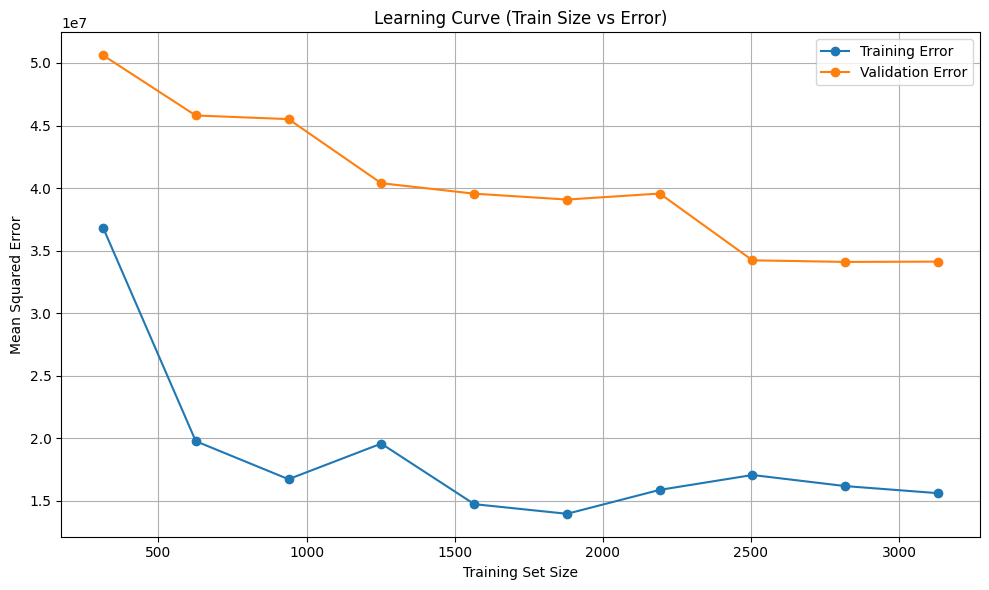

In [46]:
X_tr = best_trial.user_attrs.get("x_tr")
y_tr = best_trial.user_attrs.get("y_tr")

plot_learning_curve_vs_data_size(best_model, x_tr, y_tr)

The training curve looks good — both the training error and validation error decrease as more samples are added.

In [47]:
X_test_transformed = transform_with_best_pipeline(X_test, num_imputer, cat_imputer, encoder, scaler,extractor, X_train.columns)
y_pred = model.predict(X_test_transformed)
y_pred = np.clip(y_pred, a_min=0, a_max=None)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4, 8, 9, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Evaluace

In [48]:
# evaluation is performed on the last fold from cross-val, no fixed val set
y_val_pred =  model.predict(x_val)
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
r2 = r2_score(y_val, y_val_pred)

print(f"Mean Absolute Error (MAE):            {mae:,.2f}")
print(f"Mean Squared Error (MSE):             {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE):       {rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² (coefficient of determination):     {r2:.4f}")

Mean Absolute Error (MAE):            1,530.58
Mean Squared Error (MSE):             71,635,071.20
Root Mean Squared Error (RMSE):       8,463.75
Mean Absolute Percentage Error (MAPE): 52.17%
R² (coefficient of determination):     0.4553


In [49]:
# last folds from cross-val, no fixed train set
y_tr_pred =  model.predict(X_tr)
mae = mean_absolute_error(y_tr, y_tr_pred)
mse = mean_squared_error(y_tr, y_tr_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_tr - y_tr_pred) / y_tr)) * 100
r2 = r2_score(y_tr, y_tr_pred)

print(f"Mean Absolute Error (MAE):            {mae:,.2f}")
print(f"Mean Squared Error (MSE):             {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE):       {rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² (coefficient of determination):     {r2:.4f}")

Mean Absolute Error (MAE):            1,047.00
Mean Squared Error (MSE):             14,148,066.12
Root Mean Squared Error (RMSE):       3,761.39
Mean Absolute Percentage Error (MAPE): 44.80%
R² (coefficient of determination):     0.7135


In [50]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE):            {mae:,.2f}")
print(f"Mean Squared Error (MSE):             {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE):       {rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² (coefficient of determination):     {r2:.4f}")

Mean Absolute Error (MAE):            1,087.39
Mean Squared Error (MSE):             15,754,245.39
Root Mean Squared Error (RMSE):       3,969.16
Mean Absolute Percentage Error (MAPE): 45.59%
R² (coefficient of determination):     0.6197


It seems that outliers have a significant impact on performance scores. Therefore, it's recommended to visualize each observation.


Actual vs Predicted

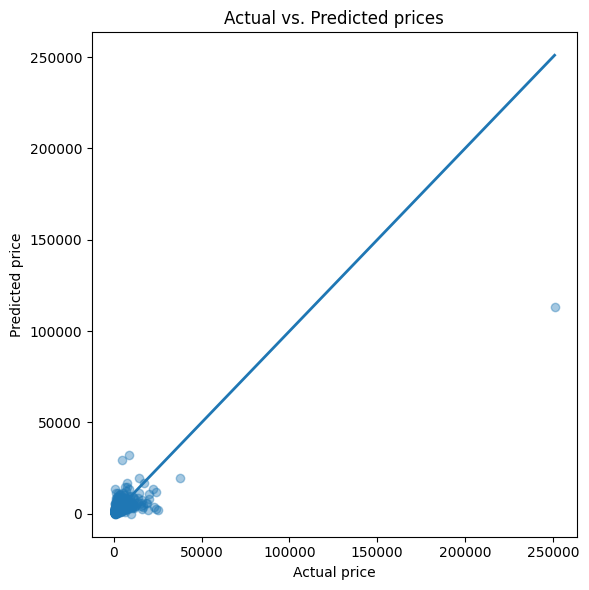

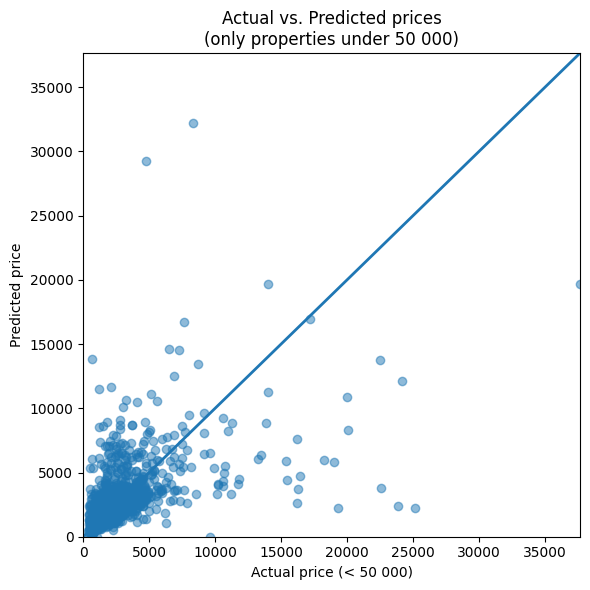

In [51]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
lim = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lim, lim, lw=2)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Actual vs. Predicted prices")
plt.tight_layout()
plt.show()


mask = y_test < 50_000
y_test_low  = y_test[mask]
y_pred_low  = y_pred[mask]
plt.figure(figsize=(6, 6))
plt.scatter(y_test_low, y_pred_low, alpha=0.5)
lim = [
    min(y_test_low.min(),  y_pred_low.min()),
    max(y_test_low.max(),  y_pred_low.max())]
plt.plot(lim, lim, lw=2)
plt.xlim(lim);  plt.ylim(lim)
plt.xlabel("Actual price (< 50 000)")
plt.ylabel("Predicted price")
plt.title("Actual vs. Predicted prices\n(only properties under 50 000)")
plt.tight_layout()
plt.show()

Residuals

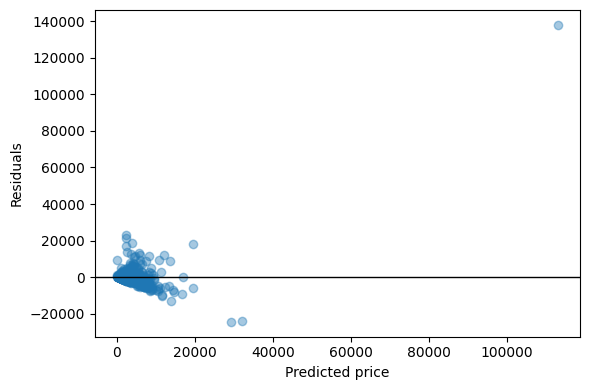

In [52]:
residuals = y_test - y_pred

fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(y_pred, residuals, alpha=0.4)
ax.axhline(0, c="k", lw=1)
ax.set_xlabel("Predicted price")
ax.set_ylabel("Residuals")
plt.tight_layout()
plt.show()

The test set contains outliers, which are part of real-world data (therefore should be included in test set). However, for business purposes, we could consider removing these extreme cases from the test set and evaluating the metrics on the remaining 90% of the data. This step could make the product more appealing to customers.

Feature Importances

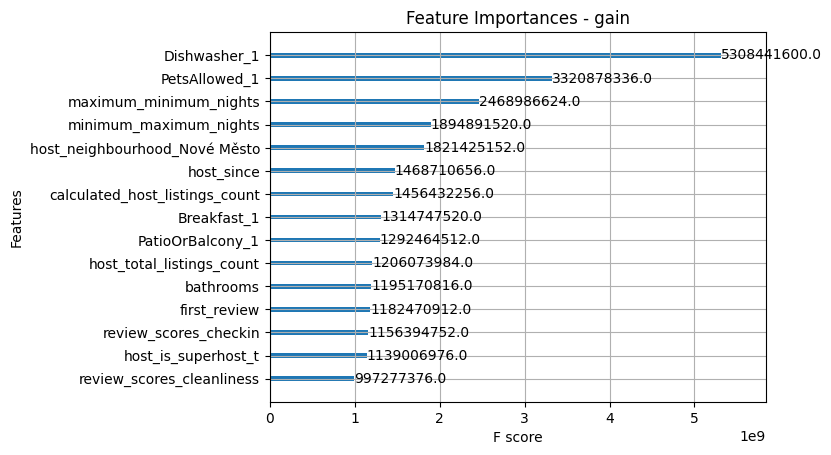

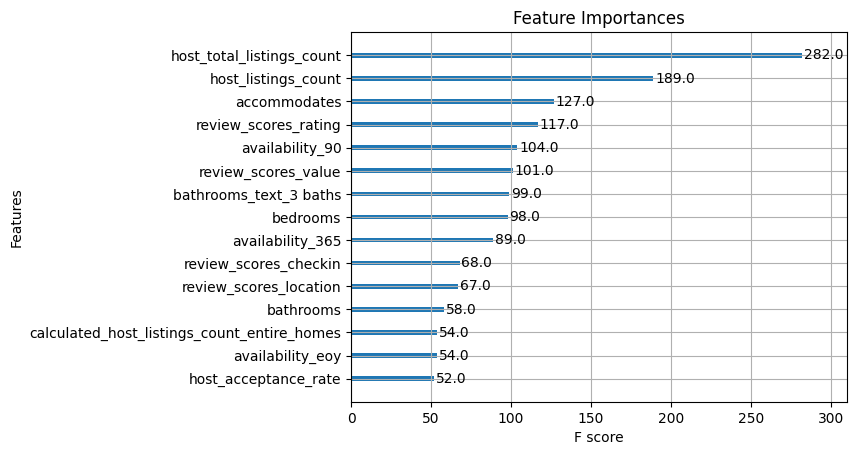

In [53]:
xgb.plot_importance(best_model, max_num_features=15, importance_type="gain")
plt.title("Feature Importances - gain")
plt.show()

xgb.plot_importance(best_model, max_num_features=15)
plt.title("Feature Importances")
plt.show()

Permutation Importance

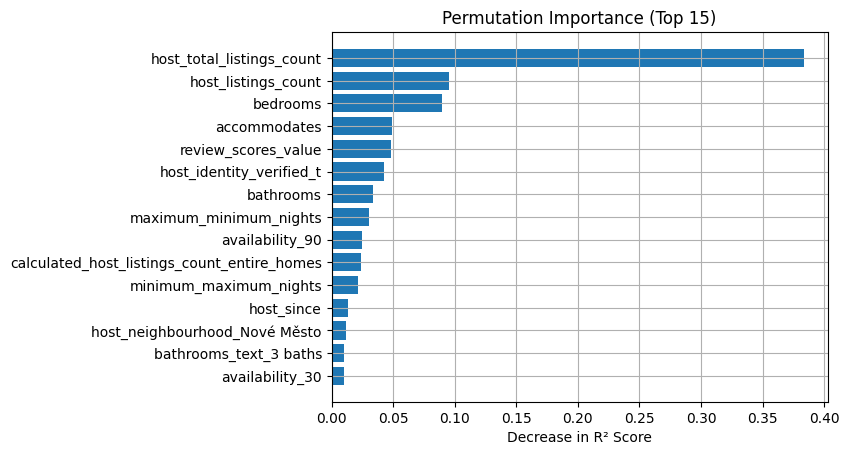

In [54]:
result = permutation_importance(best_model, X_test_transformed, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]

plt.barh(np.array(X_test_transformed.columns)[sorted_idx][:15][::-1],
         result.importances_mean[sorted_idx][:15][::-1])
plt.title("Permutation Importance (Top 15)")
plt.xlabel("Decrease in R² Score")
plt.grid(True)
plt.show()

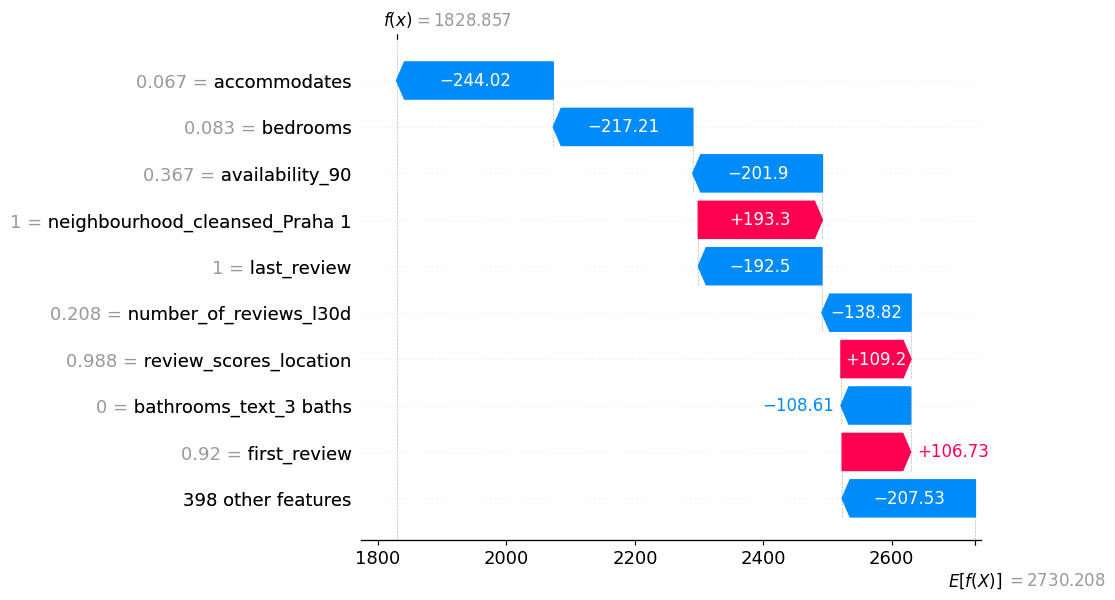

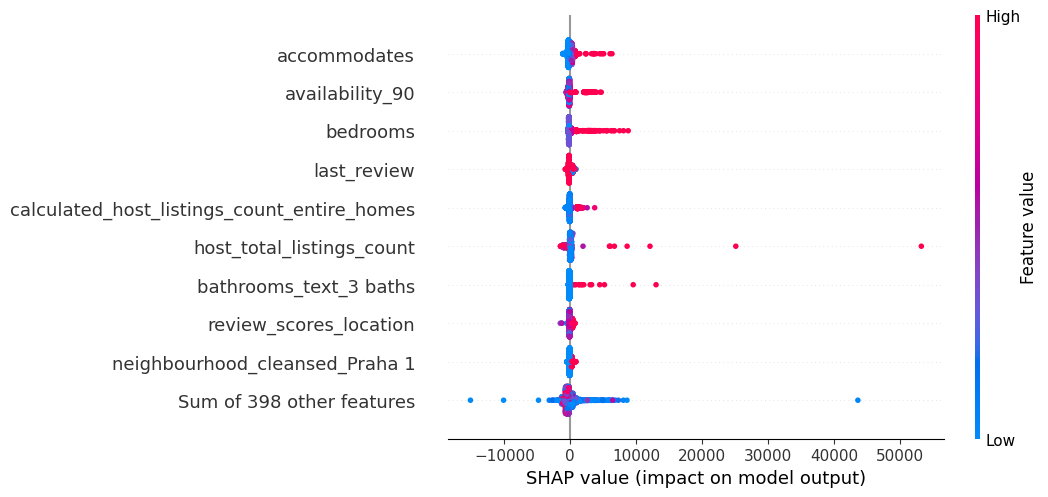

In [55]:
background = shap.sample(X_test_transformed, 100)

explainer = shap.Explainer(model, background)
shap_values = explainer(X_test_transformed)

shap.plots.waterfall(shap_values[0])
shap.plots.beeswarm(shap_values)

The first chart shows how each feature contributed to a single observation. The second chart shows the distribution of SHAP values for all observations.
